In [1]:
import numpy as np
import glob
from astropy.io import fits
from scipy.ndimage import zoom  # We'll use zoom instead of skimage.transform.resize

def open_file(name=None, raw=False, normalized=False, hdr=False, convert=False):
    """
    Translated from the IDL function:

    open_file, name, raw=raw, normalized=normalized, hdr=hdr, convert=convert

    Parameters
    ----------
    name : str or None
        Glob pattern pointing to the directory with FITS/FTS files.
        If None, defaults to:
        '/Users/vpereir1/Desktop/SynCOM_project/data/STEREO_data/*.fts'
    raw : bool
        If True, do NOT congrid (resample). If False, congrid to shape (360, nt, ny).
    normalized : bool
        If True, normalize each "slice" along the y dimension.
    hdr : bool
        Placeholder to mimic IDL keyword usage; in this code, we won't store headers
        unless you specifically want them returned.
    convert : bool
        If True, rearrange array from (nx, nt, ny) to (nx, ny, nt).

    Returns
    -------
    data : np.ndarray
        3D data array in shape (nx, nt, ny), unless `convert=True`,
        in which case it returns (nx, ny, nt).
    """

    # -------------------------------------------------------------------------
    # 1) Handle default name pattern
    # -------------------------------------------------------------------------
    if name is None:
        name = "/Users/vpereir1/Desktop/SynCOM_project/data/STEREO_data/*.fts"

    # -------------------------------------------------------------------------
    # 2) Grab the list of files matching the pattern
    # -------------------------------------------------------------------------
    file_list = sorted(glob.glob(name))
    if len(file_list) == 0:
        raise FileNotFoundError(f"No files found matching {name}")

    # -------------------------------------------------------------------------
    # 3) Read the first file to get its shape
    # -------------------------------------------------------------------------
    with fits.open(file_list[0]) as hdul:
        first_img = hdul[0].data
    nx, ny = first_img.shape
    nt = len(file_list)
    
    print(nx,ny,nt)

    # -------------------------------------------------------------------------
    # 4) Read all files into a (nx, nt, ny) data cube
    # -------------------------------------------------------------------------
    data = np.zeros((nx, nt, ny), dtype=np.float64)
    for i, filename in enumerate(file_list):
        with fits.open(filename) as hdul:
            img = hdul[0].data.astype(np.float64)
            if img.shape != (nx, ny):
                # If shapes vary, you need more logic to handle or skip them
                raise ValueError(f"File {filename} has shape {img.shape}, expected ({nx}, {ny})")
            data[:, i, :] = img

    # -------------------------------------------------------------------------
    # 5) Correct specific “bad” pixels by averaging neighbors
    # -------------------------------------------------------------------------
    bad_x_indices = [2712, 2718, 2724, 2726, 2728, 2729,
                     2735, 2737, 2738, 2739, 2740, 2741, 2893]
    # Check shape to avoid index errors
    if (max(bad_x_indices) < nx) and (339 < nt) and (145 < ny) and (340 < nt) and (146 < ny):
        for xidx in bad_x_indices:
            data[xidx, 339, 145] = 0.5 * (data[xidx, 338, 144] + data[xidx, 340, 146])
    else:
        print("Warning: shape is too small for the specified bad-pixel corrections.")

    # -------------------------------------------------------------------------
    # 6) If raw=False, we replicate IDL’s "congrid(data, 360, nt, ny)"
    #    That means we want (nx -> 360, nt -> nt, ny -> ny).
    #    We'll use scipy.ndimage.zoom to resize only the first dimension.
    # -------------------------------------------------------------------------
    if not raw:
        desired_ny = 360
        scale_y = desired_ny / ny  # factor by which to scale the x-dimension
        # We keep nt and ny the same, so scale factors are 1 for those dims.
        data = zoom(data, (1.0, 1.0, scale_y), order=1)  # order=1 -> linear interpolation

    # -------------------------------------------------------------------------
    # 7) If convert=True, rearrange dimensions from (nx, nt, ny) to (nx, ny, nt).
    # -------------------------------------------------------------------------
    if convert:
        data = np.transpose(data, (0, 2, 1))
        return data

    # -------------------------------------------------------------------------
    # 8) If normalized=True, do normalization for each y-slice (i.e., data[:, :, y])
    # -------------------------------------------------------------------------
    if normalized:
        _, nt2, ny2 = data.shape
        for yidx in range(ny2):
            slice_2d = data[:, :, yidx]
            mean_val = np.mean(slice_2d)
            std_val = np.std(slice_2d)
            if std_val != 0.0:
                slice_2d = (slice_2d - mean_val) / std_val
            else:
                slice_2d = slice_2d - mean_val
            data[:, :, yidx] = slice_2d

        return data

    # -------------------------------------------------------------------------
    # 9) Return the final data if none of the above conditions triggered.
    # -------------------------------------------------------------------------
    return data


In [2]:
data_cube = open_file(name=None, raw=True)  # or adjust raw, normalized, etc.

659 3600 848


    Header size is not multiple of 2880: 32
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


In [3]:
data_cube.shape

(659, 848, 3600)

659 3600 848


    Header size is not multiple of 2880: 32
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


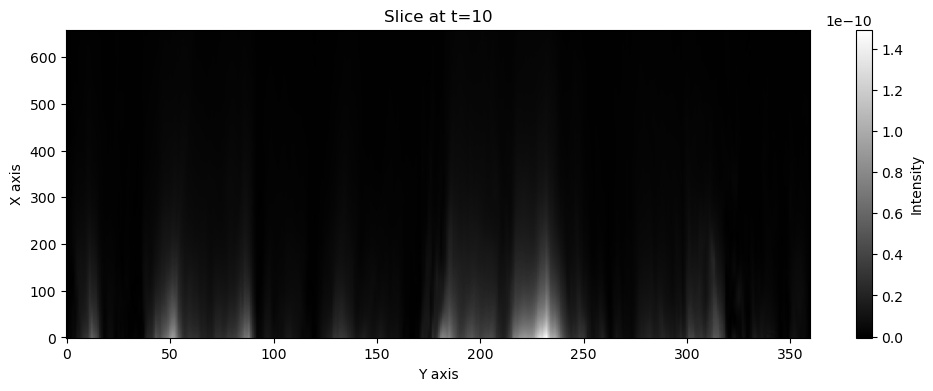

In [4]:
import matplotlib.pyplot as plt

def test_open_file_slice(name_pattern=None):
    """
    Test function to show how to use `open_file` and plot a slice.
    """
    # Grab the data cube
    data_cube = open_file(name=name_pattern, raw=False)  # or adjust raw, normalized, etc.
    
    # Let's pick t=10 (assuming we have at least 11 frames!)
    slice_index = 10
    if data_cube.shape[1] <= slice_index:
        raise IndexError(f"Cube does not have index {slice_index} in the 't' dimension.")

    # Extract that slice: data_cube[:, 10, :]
    image_slice = data_cube[:, slice_index, :]

    plt.figure(figsize=(12, 4))
    plt.imshow(image_slice, origin='lower', cmap='gray', aspect='auto')
    plt.colorbar(label='Intensity')
    plt.title(f"Slice at t={slice_index}")
    plt.xlabel('Y axis')
    plt.ylabel('X axis')
    plt.show()

# Example usage:
test_open_file_slice("/Users/vpereir1/Desktop/SynCOM_project/data/STEREO_data/*.fts")


659 3600 848


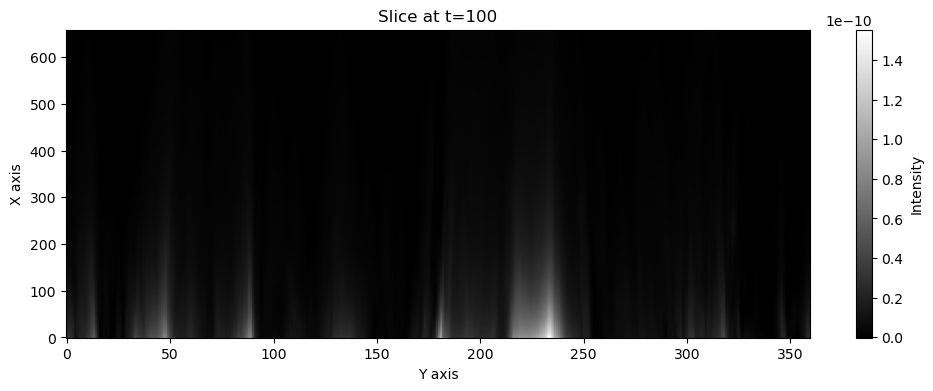

In [5]:
import matplotlib.pyplot as plt

def test_open_file_slice(name_pattern=None):
    """
    Test function to show how to use `open_file` and plot a slice.
    """
    # Grab the data cube
    data_cube = open_file(name=name_pattern, raw=False)  # or adjust raw, normalized, etc.
    
    # Let's pick t=10 (assuming we have at least 11 frames!)
    slice_index = 100
    if data_cube.shape[1] <= slice_index:
        raise IndexError(f"Cube does not have index {slice_index} in the 't' dimension.")

    # Extract that slice: data_cube[:, slice_index, :]
    image_slice = data_cube[:, slice_index, :]

    plt.figure(figsize=(12, 4))
    plt.imshow(image_slice, origin='lower', cmap='gray', aspect='auto')
    plt.colorbar(label='Intensity')
    plt.title(f"Slice at t={slice_index}")
    plt.xlabel('Y axis')
    plt.ylabel('X axis')
    plt.show()

# Example usage:
test_open_file_slice("/Users/vpereir1/Desktop/SynCOM_project/data/STEREO_data/*.fts")


659 3600 848


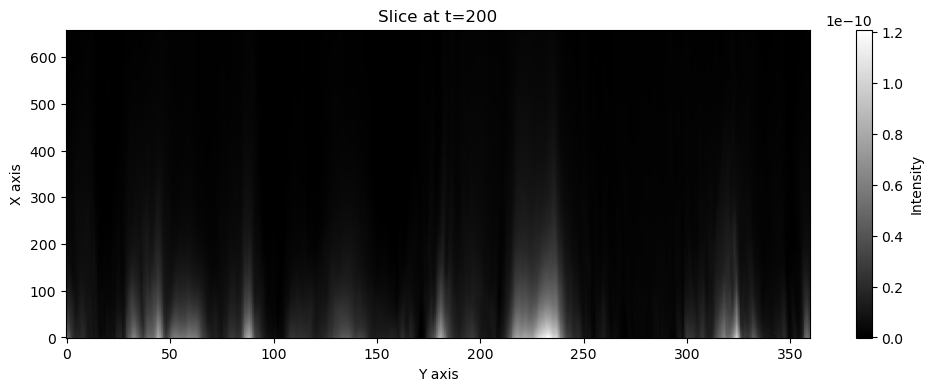

In [6]:
import matplotlib.pyplot as plt

def test_open_file_slice(name_pattern=None):
    """
    Test function to show how to use `open_file` and plot a slice.
    """
    # Grab the data cube
    data_cube = open_file(name=name_pattern, raw=False)  # or adjust raw, normalized, etc.
    
    # Let's pick t=10 (assuming we have at least 11 frames!)
    slice_index = 200
    if data_cube.shape[1] <= slice_index:
        raise IndexError(f"Cube does not have index {slice_index} in the 't' dimension.")

    # Extract that slice: data_cube[:, slice_index, :]
    image_slice = data_cube[:, slice_index, :]

    plt.figure(figsize=(12, 4))
    plt.imshow(image_slice, origin='lower', cmap='gray', aspect='auto')
    plt.colorbar(label='Intensity')
    plt.title(f"Slice at t={slice_index}")
    plt.xlabel('Y axis')
    plt.ylabel('X axis')
    plt.show()

# Example usage:
test_open_file_slice("/Users/vpereir1/Desktop/SynCOM_project/data/STEREO_data/*.fts")


659 3600 848


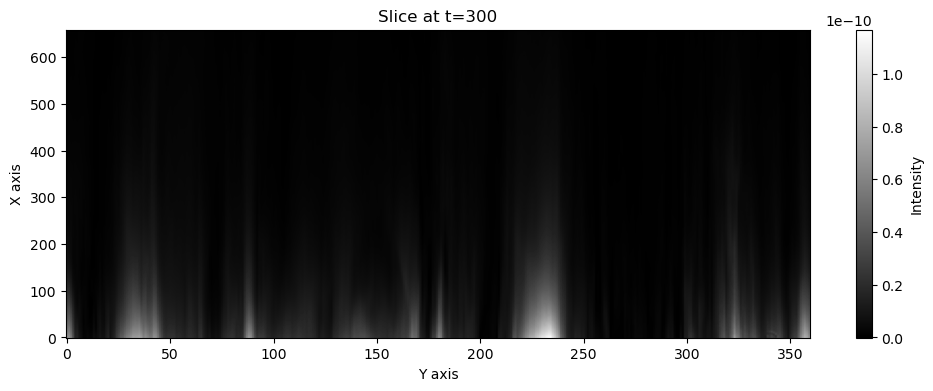

In [7]:
import matplotlib.pyplot as plt

def test_open_file_slice(name_pattern=None):
    """
    Test function to show how to use `open_file` and plot a slice.
    """
    # Grab the data cube
    data_cube = open_file(name=name_pattern, raw=False)  # or adjust raw, normalized, etc.
    
    # Let's pick t=10 (assuming we have at least 11 frames!)
    slice_index = 300
    if data_cube.shape[1] <= slice_index:
        raise IndexError(f"Cube does not have index {slice_index} in the 't' dimension.")

    # Extract that slice: data_cube[:, slice_index, :]
    image_slice = data_cube[:, slice_index, :]

    plt.figure(figsize=(12, 4))
    plt.imshow(image_slice, origin='lower', cmap='gray', aspect='auto')
    plt.colorbar(label='Intensity')
    plt.title(f"Slice at t={slice_index}")
    plt.xlabel('Y axis')
    plt.ylabel('X axis')
    plt.show()

# Example usage:
test_open_file_slice("/Users/vpereir1/Desktop/SynCOM_project/data/STEREO_data/*.fts")


659 3600 848


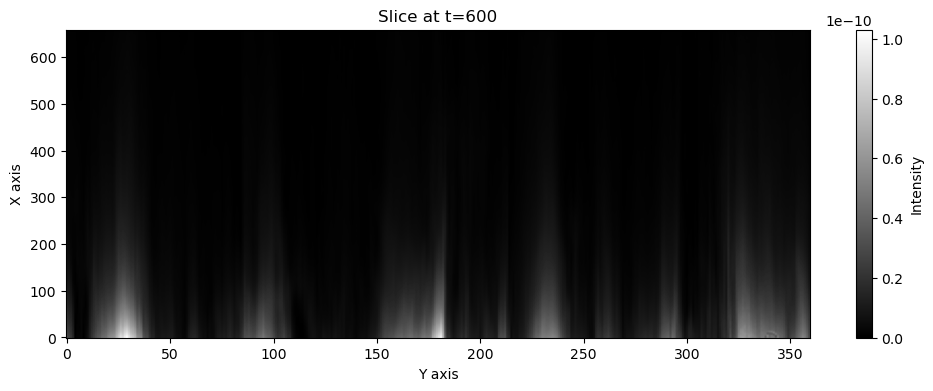

In [8]:
import matplotlib.pyplot as plt

def test_open_file_slice(name_pattern=None):
    """
    Test function to show how to use `open_file` and plot a slice.
    """
    # Grab the data cube
    data_cube = open_file(name=name_pattern, raw=False)  # or adjust raw, normalized, etc.
    
    # Let's pick t=10 (assuming we have at least 11 frames!)
    slice_index = 600
    if data_cube.shape[1] <= slice_index:
        raise IndexError(f"Cube does not have index {slice_index} in the 't' dimension.")

    # Extract that slice: data_cube[:, slice_index, :]
    image_slice = data_cube[:, slice_index, :]

    plt.figure(figsize=(12, 4))
    plt.imshow(image_slice, origin='lower', cmap='gray', aspect='auto')
    plt.colorbar(label='Intensity')
    plt.title(f"Slice at t={slice_index}")
    plt.xlabel('Y axis')
    plt.ylabel('X axis')
    plt.show()

# Example usage:
test_open_file_slice("/Users/vpereir1/Desktop/SynCOM_project/data/STEREO_data/*.fts")
